In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
import seaborn as sns
import os
import spacy
import string
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
data = pd.read_csv('train_cap2018.csv', encoding='utf-8')

In [7]:
data['tokens_gensim'] = data.fulltext.apply(lambda x: gensim.utils.simple_preprocess(x))

In [8]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_lg')

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [9]:
import time
start = time.time()
fulltext_cleaned = cleanup_text(data.fulltext, logging=True)
end = time.time()
print("Processed all documents in {} mins".format((end-start)/60))

Processed 1000 out of 27310 documents.
Processed 2000 out of 27310 documents.
Processed 3000 out of 27310 documents.
Processed 4000 out of 27310 documents.
Processed 5000 out of 27310 documents.
Processed 6000 out of 27310 documents.
Processed 7000 out of 27310 documents.
Processed 8000 out of 27310 documents.
Processed 9000 out of 27310 documents.
Processed 10000 out of 27310 documents.
Processed 11000 out of 27310 documents.
Processed 12000 out of 27310 documents.
Processed 13000 out of 27310 documents.
Processed 14000 out of 27310 documents.
Processed 15000 out of 27310 documents.
Processed 16000 out of 27310 documents.
Processed 17000 out of 27310 documents.
Processed 18000 out of 27310 documents.
Processed 19000 out of 27310 documents.
Processed 20000 out of 27310 documents.
Processed 21000 out of 27310 documents.
Processed 22000 out of 27310 documents.
Processed 23000 out of 27310 documents.
Processed 24000 out of 27310 documents.
Processed 25000 out of 27310 documents.
Processed

In [10]:
data["spacy_text"] = fulltext_cleaned

c2_text = [txt for txt in data[data["level1"] == 'C2']["spacy_text"]]
c1_text = [txt for txt in data[data["level1"] == 'C1']["spacy_text"]]
b2_text = [txt for txt in data[data["level1"] == 'B2']["spacy_text"]]
b1_text = [txt for txt in data[data["level1"] == 'B1']["spacy_text"]]
a2_text = [txt for txt in data[data["level1"] == 'A2']["spacy_text"]]
a1_text = [txt for txt in data[data["level1"] == 'A1']["spacy_text"]]

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

nd = data[["fulltext", "level1"]]
nd.columns = ["fulltext", "level"]
for train_index, test_index in sss.split(nd.fulltext, nd.level):
    train_index = train_index
    test_index = test_index
    print(train_index, test_index)

train = nd.loc[train_index]
valid = nd.loc[test_index]

(array([ 8986, 22314, 21074, ...,  6745, 10746,  3544]), array([25875,  9450, 17137, ..., 15377, 25553, 10751]))


In [39]:
train.to_json("train.txt", lines=True, orient='records')
valid.to_json("valid.txt", lines=True, orient='records')

In [9]:
from collections import Counter

#count all unique words
c2_count_words = Counter(' '.join(c2_text).split())
c1_count_words = Counter(' '.join(c1_text).split())
b2_count_words = Counter(' '.join(b2_text).split())
b1_count_words = Counter(' '.join(b1_text).split())
a2_count_words = Counter(' '.join(a2_text).split())
a1_count_words = Counter(' '.join(a1_text).split())

c2_common_words = [word[0] for word in c2_count_words.most_common(25)]
c2_common_count = [word[1] for word in c2_count_words.most_common(25)]

c1_common_words = [word[0] for word in c1_count_words.most_common(25)]
c1_common_count = [word[1] for word in c1_count_words.most_common(25)]

b2_common_words = [word[0] for word in b2_count_words.most_common(25)]
b2_common_count = [word[1] for word in b2_count_words.most_common(25)]

b1_common_words = [word[0] for word in b1_count_words.most_common(25)]
b1_common_count = [word[1] for word in b1_count_words.most_common(25)]

a2_common_words = [word[0] for word in a2_count_words.most_common(25)]
a2_common_count = [word[1] for word in a2_count_words.most_common(25)]

a1_common_words = [word[0] for word in a1_count_words.most_common(25)]
a1_common_count = [word[1] for word in a1_count_words.most_common(25)]

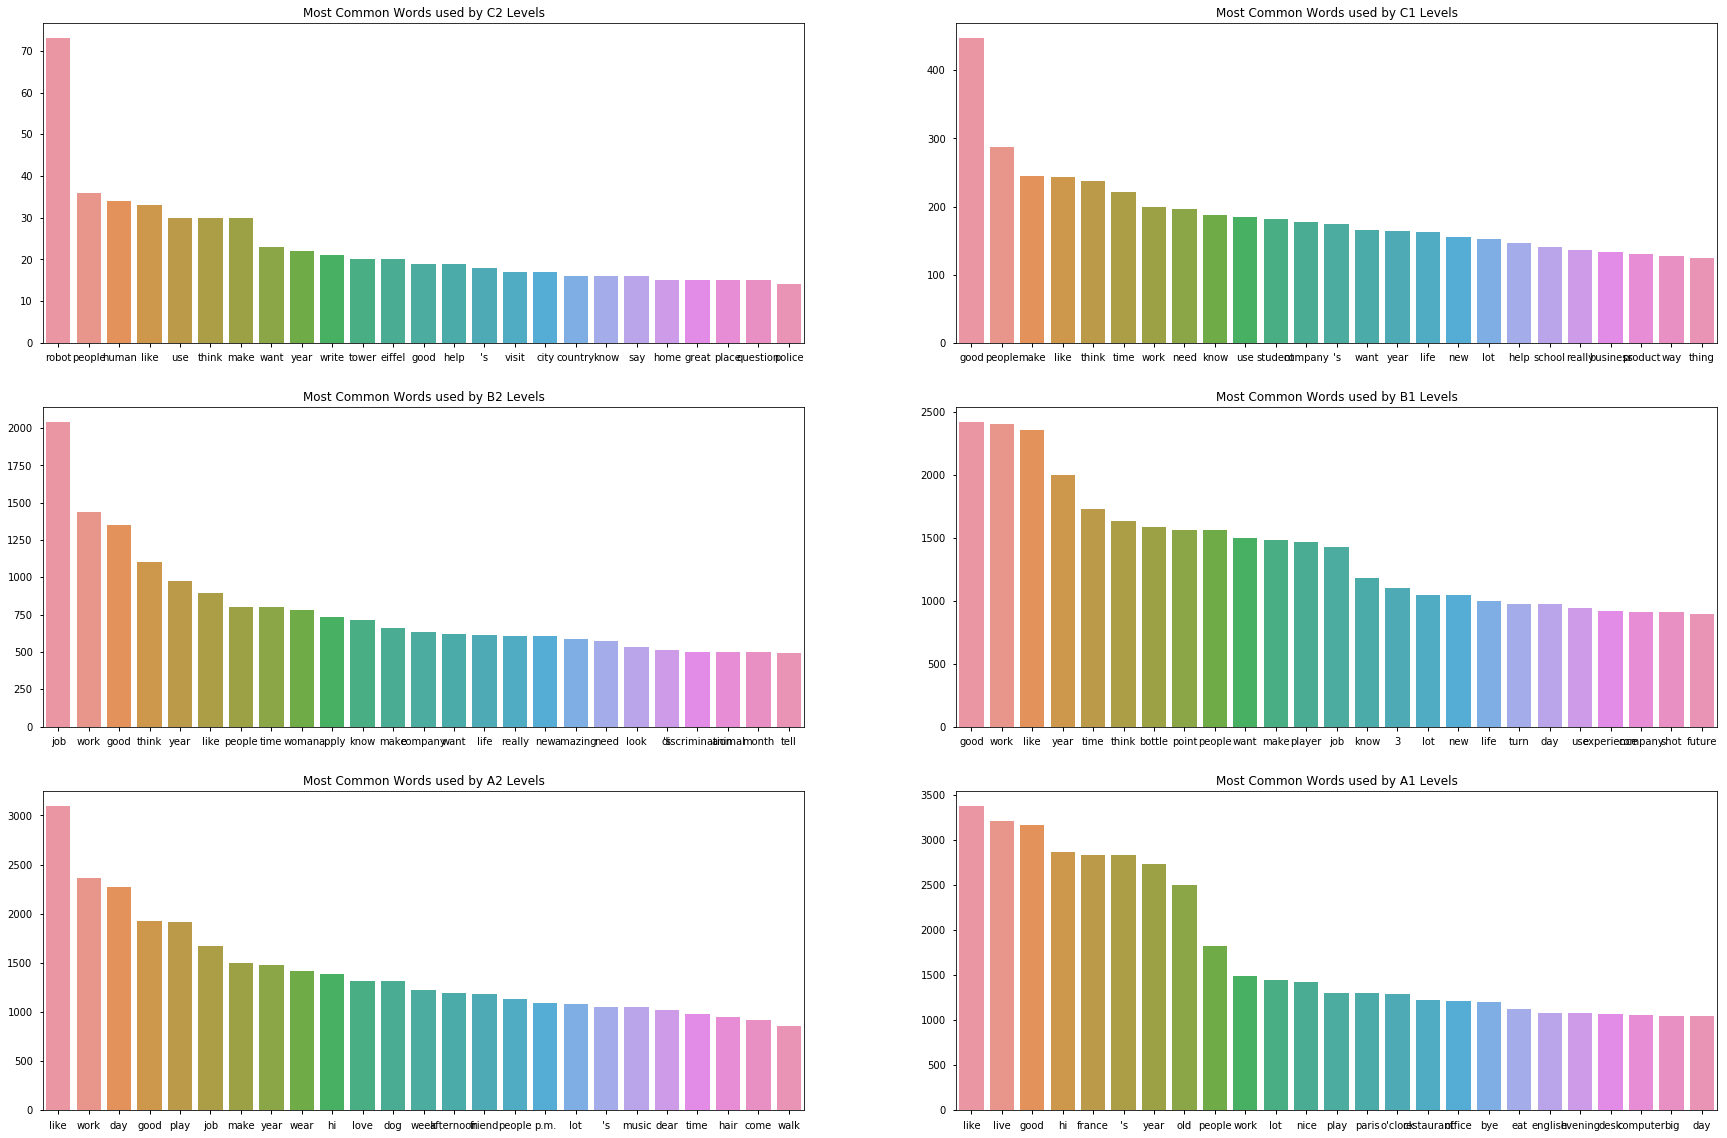

In [12]:
sns.set_context('notebook')
couples = [(c2_common_words, c2_common_count), 
           (c1_common_words, c1_common_count),
           (b2_common_words, b2_common_count),
           (b1_common_words, b1_common_count),
           (a2_common_words, a2_common_count),
           (a1_common_words, a1_common_count)]
fig=plt.figure(figsize=(30, 20))
ax1 = fig.add_subplot(321)
sns.barplot(x=c2_common_words, y=c2_common_count,ax=ax1)
plt.title('Most Common Words used by C2 Levels')
ax2 = fig.add_subplot(322)
sns.barplot(x=c1_common_words, y=c1_common_count, ax=ax2)
plt.title('Most Common Words used by C1 Levels')
ax3 = fig.add_subplot(323)
sns.barplot(x=b2_common_words, y=b2_common_count, ax=ax3)
plt.title('Most Common Words used by B2 Levels')
ax4 = fig.add_subplot(324)
sns.barplot(x=b1_common_words, y=b1_common_count, ax=ax4)
plt.title('Most Common Words used by B1 Levels')
ax5 = fig.add_subplot(325)
sns.barplot(x=a2_common_words, y=a2_common_count, ax=ax5)
plt.title('Most Common Words used by A2 Levels')
ax6 = fig.add_subplot(326)
sns.barplot(x=a1_common_words, y=a1_common_count, ax=ax6)
plt.title('Most Common Words used by A1 Levels')


plt.show()

In [13]:
#Spam..
print(data.loc[27291,:]['fulltext'])

## Compute spell check feature

In [51]:
def spellratio(word, nlp):
    if word in nlp.vocab:
        return 1
    return 0

def count_spell(l, nlp):
    return float(reduce(lambda x,y:x+y, map(lambda x: spellratio(x, nlp), l))) / len(l)

data['ratio_spell'] = data["tokens_gensim"].apply(lambda l: count_spell(l, nlp))

## Model

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
from sklearn import model_selection, cross_validation
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import *

/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [56]:
train_cols = data.columns.tolist()
train_cols.remove("text")
train_cols.remove("fulltext")
train_cols.remove("MATTR")
train_cols.remove("MSTTR")
train_cols.remove("spacy_text")
train_cols.remove("level1")
train_cols.remove("tokens_gensim")
target = "level1"

Y = data[target].astype('str')
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

In [59]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[train_cols], label_encoded_y, test_size=test_size, random_state=seed)
# fit model no training data

parameters = {'objective':'multi:softprob',
              'num_class': 6,
              'n_thread': 4,
              'n_jobs': 7,
              'learning_rate': 0.01, #so called `eta` value
              'max_depth': 8,
              'min_child_weight': 11,
              'silent': [1],
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 1000, #number of trees, change it to 1000 for better results
              'seed': 1337}

xgtrain = xgboost.DMatrix(data[train_cols], label=label_encoded_y)
model = xgboost.XGBClassifier(**parameters)
xgb_param = model.get_xgb_params()
#do cross validation
print ('Start cross validation')
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['merror'],
     early_stopping_rounds=50, stratified=True, seed=1337)

print('Best number of trees = {}'.format(cvresult.shape[0]))
model.set_params(n_estimators=cvresult.shape[0])
print('Fit on the trainingsdata')
model.fit(data[train_cols], label_encoded_y, eval_metric='merror')

Start cross validation
Best number of trees = 1174
Fit on the trainingsdata


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=11, missing=None, n_estimators=1174,
       n_jobs=7, n_thread=4, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=[1],
       subsample=0.7)

In [60]:
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=11, missing=None, n_estimators=1174,
       n_jobs=7, n_thread=4, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=[1],
       subsample=0.7)
Accuracy: 87.98%


/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [67]:
from sklearn.metrics import f1_score, recall_score

print 'f1 score: {}'.format(f1_score(y_test, y_pred, average=None).mean())
print 'recall score: {}'.format(recall_score(y_test, y_pred, average=None).mean())

f1 score: 0.782457197647
recall score: 0.739218159346


Our ratio spell seems to directly impact inference for the xgboost :

Populating the interactive namespace from numpy and matplotlib


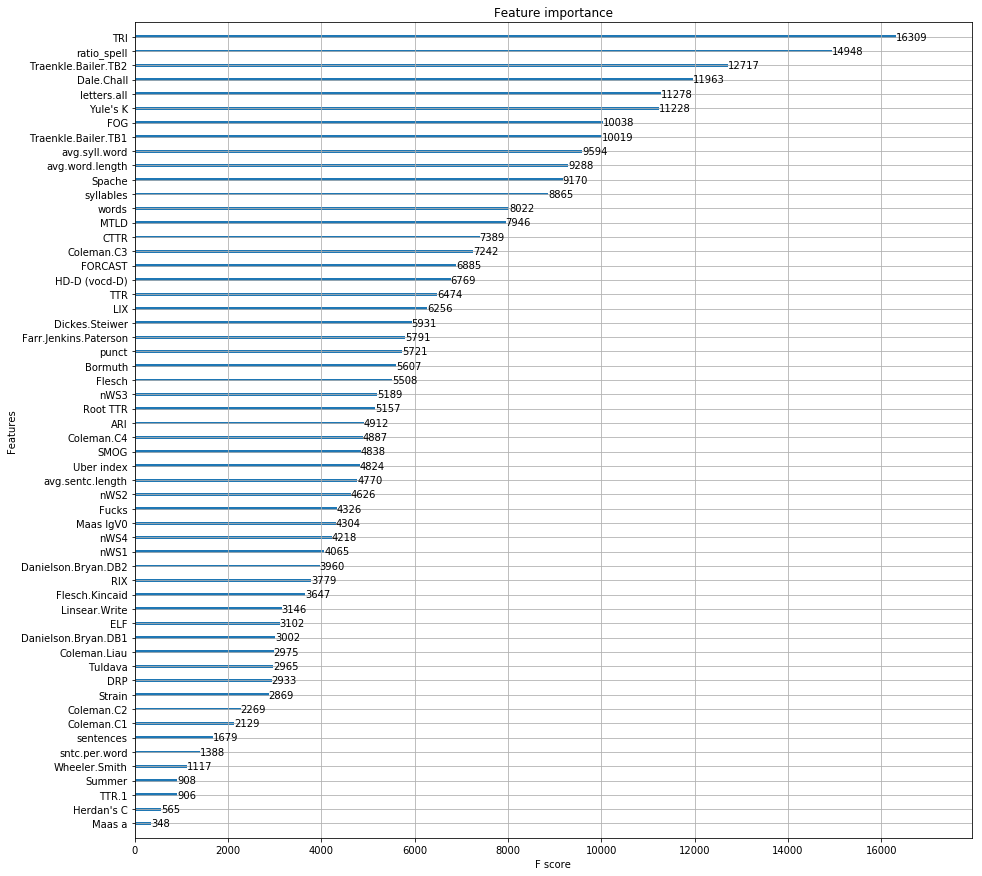

In [71]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)
from xgboost import plot_importance

plot_importance(model)